In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from adamw import AdamW
from nadam import Nadam
from uoptim import UOptimizer


from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from utils_exp import plot_graphs

import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PATH = './fMNIST_data'

cuda:0


In [2]:
train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transforms.ToTensor())

# calculate statistics for fashion MNIST
global_norm_mean = train_data.train_data.float().div(255).mean().item()
global_norm_std = train_data.train_data.float().div(255).std().item()

In [3]:
# util to create loaders
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((global_norm_mean,), (global_norm_std,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path=PATH):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='UAdam', **optim_params):
        super(Net, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'AdamW':
            self.optim = AdamW(self.parameters(), **optim_params)
        elif optim_type == 'Nadam':
            self.optim = Nadam(self.parameters(), **optim_params)
        elif optim_type == 'Adamax':
            self.optim = optim.Adamax(self.parameters(), **optim_params)
        elif optim_type == 'UOptimizer':
            self.optim = UOptimizer(params = self.parameters(), **optim_params)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [8]:
models = {
          # testing correctness of SGD
          'SGD': Net(True, False, 'SGD', lr=1e-3).to(device), 
          'UOSGD': Net(True, False, 'UOptimizer', lr=1e-3).to(device), 
    
          'SGD_momentum':Net(True, False, 'SGD', momentum=0.9, lr=1e-3).to(device),
          'UOSGD_momentum':Net(True, False, 'UOptimizer', optimizer = 'SGDM', beta1_dump=0, lr=1e-3).to(device),
    
          'SGD_momentum_n':Net(True, False, 'SGD', momentum=0.9, nesterov=True,  lr=1e-3).to(device),
          'UOSGD_momentum_n':Net(True, False, 'UOptimizer',  optimizer='SGDNM', beta1_dump=0, lr=1e-3).to(device),
    
          # testing RMSProp      
          'RMSProp': Net(True, False, 'RMSProp', lr=1e-4).to(device), 
          'UORMSProp': Net(True, False, 'UOptimizer', optimizer='RMSProp',  betas = (0, 0.99), lr=1e-4).to(device), 
          
          # testing Adadelta
          'Adadelta':Net(True, False, 'Adadelta', lr=1).to(device),
          'UOAdadelta':Net(True, False, 'UOptimizer', optimizer='Adadelta', lr=1, betas = (0, 0.9), eps=1e-6).to(device),
            
          # testing adam-like algoritms. 
          'Adam': Net(True, False, 'Adam', lr=1e-4).to(device), 
          'UOAdam': Net(True, False, 'UOptimizer', optimizer='Adam', lr=1e-4).to(device), 
    
          'Amsgrad':Net(True, False, 'Adam', lr=1e-4, amsgrad=True).to(device),
          'UOAmsgrad':Net(True, False, 'UOptimizer', optimizer='Amsgrad', lr=1e-4).to(device), 
          
          # AdamW is not included in Pytorch, so I used fastai implementation from here:
          # https://github.com/anandsaha/fastai.part1.v2/commit/159e1712e60f299e11c42caab35c726f367bcd61
          'AdamW':Net(True, False, 'AdamW', lr=1e-4, weight_decay=0.00025).to(device),
          'UOAdamW':Net(True, False, 'UOptimizer', optimizer='AdamW', lr=1e-4, weight_decay=0.00025).to(device),
    
          # Please note that pytorch Nadam is the official Nadam implementation for Keras translated to PyTorch
          # I use the classical Nadam formulas, so the results could be differ
          'Nadam':Net(True, False, 'Nadam', lr=1e-4).to(device),
          'UONadam':Net(True, False, 'UOptimizer', optimizer='Nadam',  lr=1e-4).to(device),
          
          'Adamax':Net(True, False, 'Adamax', lr=1e-4).to(device),
          'UOAdamax':Net(True, False, 'UOptimizer', optimizer='Adamax', lr=1e-4).to(device),
    
    
          # create exotic combinations for fun
          'Adam_with_adadelta_coeff':Net(True, False, 'UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_adadelta_lr = True,
                                         use_bias_correction = True,
                                         lr=1).to(device),
          'Adam_with_exp_avg_norm_like_sgd':Net(True, False, 'UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_bias_correction = True,
                                         beta1_dump=0,
                                         lr=1e-4).to(device),                  
            }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

You are using the AdamW optimizer


In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
#         if batch_idx % 200 == 0:
#             line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
#                 epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
#             losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
#              print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
#         print(line + losses)

In [10]:
def test(models, loader, log=None, epoch=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = f'Test set after {epoch} epochs:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    
    if epoch % 1 == 0:
        print()
        print(report)

In [11]:
n_epoch = 100
for epoch in range(1, n_epoch+1):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log, epoch)

C:\Users\kvr\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set after 1 epochs:
SGD: Loss: 1.7576	Accuracy: 6964.0/10000 (70%)
UOSGD: Loss: 1.7979	Accuracy: 6429.0/10000 (64%)
SGD_momentum: Loss: 0.6890	Accuracy: 7715.0/10000 (77%)
UOSGD_momentum: Loss: 0.7067	Accuracy: 7637.0/10000 (76%)
SGD_momentum_n: Loss: 0.6743	Accuracy: 7795.0/10000 (78%)
UOSGD_momentum_n: Loss: 0.6826	Accuracy: 7707.0/10000 (77%)
RMSProp: Loss: 0.8403	Accuracy: 7536.0/10000 (75%)
UORMSProp: Loss: 0.7671	Accuracy: 7590.0/10000 (76%)
Adadelta: Loss: 0.3870	Accuracy: 8653.0/10000 (87%)
UOAdadelta: Loss: 0.3678	Accuracy: 8688.0/10000 (87%)
Adam: Loss: 0.8488	Accuracy: 7541.0/10000 (75%)
UOAdam: Loss: 0.8650	Accuracy: 7518.0/10000 (75%)
Amsgrad: Loss: 0.9593	Accuracy: 7411.0/10000 (74%)
UOAmsgrad: Loss: 0.8302	Accuracy: 7612.0/10000 (76%)
AdamW: Loss: 0.9786	Accuracy: 7450.0/10000 (74%)
UOAdamW: Loss: 1.0798	Accuracy: 7264.0/10000 (73%)
Nadam: Loss: 0.6869	Accuracy: 7751.0/10000 (78%)
UONadam: Loss: 0.8507	Accuracy: 7531.0/10000 (75%)
Adamax: Loss: 1.3031	Accuracy: 710



Test set after 8 epochs:
SGD: Loss: 0.7389	Accuracy: 7641.0/10000 (76%)
UOSGD: Loss: 0.7580	Accuracy: 7648.0/10000 (76%)
SGD_momentum: Loss: 0.3395	Accuracy: 8795.0/10000 (88%)
UOSGD_momentum: Loss: 0.3458	Accuracy: 8776.0/10000 (88%)
SGD_momentum_n: Loss: 0.3394	Accuracy: 8819.0/10000 (88%)
UOSGD_momentum_n: Loss: 0.3466	Accuracy: 8766.0/10000 (88%)
RMSProp: Loss: 0.3522	Accuracy: 8741.0/10000 (87%)
UORMSProp: Loss: 0.3480	Accuracy: 8745.0/10000 (87%)
Adadelta: Loss: 0.2681	Accuracy: 9098.0/10000 (91%)
UOAdadelta: Loss: 0.2491	Accuracy: 9125.0/10000 (91%)
Adam: Loss: 0.3485	Accuracy: 8783.0/10000 (88%)
UOAdam: Loss: 0.3438	Accuracy: 8768.0/10000 (88%)
Amsgrad: Loss: 0.3968	Accuracy: 8636.0/10000 (86%)
UOAmsgrad: Loss: 0.3814	Accuracy: 8684.0/10000 (87%)
AdamW: Loss: 0.6689	Accuracy: 8070.0/10000 (81%)
UOAdamW: Loss: 0.6882	Accuracy: 7960.0/10000 (80%)
Nadam: Loss: 0.5284	Accuracy: 8149.0/10000 (81%)
UONadam: Loss: 0.3573	Accuracy: 8722.0/10000 (87%)
Adamax: Loss: 0.5052	Accuracy: 81



Test set after 15 epochs:
SGD: Loss: 0.6031	Accuracy: 7923.0/10000 (79%)
UOSGD: Loss: 0.6006	Accuracy: 7952.0/10000 (80%)
SGD_momentum: Loss: 0.2925	Accuracy: 8946.0/10000 (89%)
UOSGD_momentum: Loss: 0.2948	Accuracy: 8948.0/10000 (89%)
SGD_momentum_n: Loss: 0.2863	Accuracy: 8976.0/10000 (90%)
UOSGD_momentum_n: Loss: 0.2963	Accuracy: 8938.0/10000 (89%)
RMSProp: Loss: 0.2901	Accuracy: 8948.0/10000 (89%)
UORMSProp: Loss: 0.2826	Accuracy: 8959.0/10000 (90%)
Adadelta: Loss: 0.2984	Accuracy: 9057.0/10000 (91%)
UOAdadelta: Loss: 0.3055	Accuracy: 9052.0/10000 (91%)
Adam: Loss: 0.2858	Accuracy: 8945.0/10000 (89%)
UOAdam: Loss: 0.2771	Accuracy: 8985.0/10000 (90%)
Amsgrad: Loss: 0.3233	Accuracy: 8871.0/10000 (89%)
UOAmsgrad: Loss: 0.3165	Accuracy: 8884.0/10000 (89%)
AdamW: Loss: 0.6655	Accuracy: 8081.0/10000 (81%)
UOAdamW: Loss: 0.6791	Accuracy: 7988.0/10000 (80%)
Nadam: Loss: 0.5253	Accuracy: 8164.0/10000 (82%)
UONadam: Loss: 0.2908	Accuracy: 8943.0/10000 (89%)
Adamax: Loss: 0.3922	Accuracy: 8



Test set after 22 epochs:
SGD: Loss: 0.5361	Accuracy: 8125.0/10000 (81%)
UOSGD: Loss: 0.5265	Accuracy: 8178.0/10000 (82%)
SGD_momentum: Loss: 0.2699	Accuracy: 9014.0/10000 (90%)
UOSGD_momentum: Loss: 0.2754	Accuracy: 9000.0/10000 (90%)
SGD_momentum_n: Loss: 0.2643	Accuracy: 9019.0/10000 (90%)
UOSGD_momentum_n: Loss: 0.2730	Accuracy: 9019.0/10000 (90%)
RMSProp: Loss: 0.2673	Accuracy: 9038.0/10000 (90%)
UORMSProp: Loss: 0.2563	Accuracy: 9083.0/10000 (91%)
Adadelta: Loss: 0.2896	Accuracy: 9111.0/10000 (91%)
UOAdadelta: Loss: 0.2942	Accuracy: 9134.0/10000 (91%)
Adam: Loss: 0.2624	Accuracy: 9019.0/10000 (90%)
UOAdam: Loss: 0.2537	Accuracy: 9058.0/10000 (91%)
Amsgrad: Loss: 0.2962	Accuracy: 8943.0/10000 (89%)
UOAmsgrad: Loss: 0.2880	Accuracy: 8973.0/10000 (90%)
AdamW: Loss: 0.6629	Accuracy: 8131.0/10000 (81%)
UOAdamW: Loss: 0.6706	Accuracy: 8124.0/10000 (81%)
Nadam: Loss: 0.5243	Accuracy: 8163.0/10000 (82%)
UONadam: Loss: 0.2674	Accuracy: 9024.0/10000 (90%)
Adamax: Loss: 0.3392	Accuracy: 8



Test set after 29 epochs:
SGD: Loss: 0.4904	Accuracy: 8282.0/10000 (83%)
UOSGD: Loss: 0.4773	Accuracy: 8340.0/10000 (83%)
SGD_momentum: Loss: 0.2615	Accuracy: 9069.0/10000 (91%)
UOSGD_momentum: Loss: 0.2622	Accuracy: 9052.0/10000 (91%)
SGD_momentum_n: Loss: 0.2567	Accuracy: 9081.0/10000 (91%)
UOSGD_momentum_n: Loss: 0.2626	Accuracy: 9038.0/10000 (90%)
RMSProp: Loss: 0.2595	Accuracy: 9045.0/10000 (90%)
UORMSProp: Loss: 0.2446	Accuracy: 9112.0/10000 (91%)
Adadelta: Loss: 0.3290	Accuracy: 9097.0/10000 (91%)
UOAdadelta: Loss: 0.3529	Accuracy: 9062.0/10000 (91%)
Adam: Loss: 0.2466	Accuracy: 9078.0/10000 (91%)
UOAdam: Loss: 0.2439	Accuracy: 9089.0/10000 (91%)
Amsgrad: Loss: 0.2762	Accuracy: 8994.0/10000 (90%)
UOAmsgrad: Loss: 0.2721	Accuracy: 9022.0/10000 (90%)
AdamW: Loss: 0.6649	Accuracy: 8103.0/10000 (81%)
UOAdamW: Loss: 0.6836	Accuracy: 8104.0/10000 (81%)
Nadam: Loss: 0.5258	Accuracy: 8171.0/10000 (82%)
UONadam: Loss: 0.2558	Accuracy: 9047.0/10000 (90%)
Adamax: Loss: 0.3101	Accuracy: 8



Test set after 36 epochs:
SGD: Loss: 0.4556	Accuracy: 8411.0/10000 (84%)
UOSGD: Loss: 0.4407	Accuracy: 8492.0/10000 (85%)
SGD_momentum: Loss: 0.2488	Accuracy: 9091.0/10000 (91%)
UOSGD_momentum: Loss: 0.2597	Accuracy: 9054.0/10000 (91%)
SGD_momentum_n: Loss: 0.2448	Accuracy: 9101.0/10000 (91%)
UOSGD_momentum_n: Loss: 0.2524	Accuracy: 9058.0/10000 (91%)
RMSProp: Loss: 0.2390	Accuracy: 9124.0/10000 (91%)
UORMSProp: Loss: 0.2324	Accuracy: 9147.0/10000 (91%)
Adadelta: Loss: 0.3533	Accuracy: 9055.0/10000 (91%)
UOAdadelta: Loss: 0.3564	Accuracy: 9038.0/10000 (90%)
Adam: Loss: 0.2423	Accuracy: 9077.0/10000 (91%)
UOAdam: Loss: 0.2397	Accuracy: 9122.0/10000 (91%)
Amsgrad: Loss: 0.2699	Accuracy: 9029.0/10000 (90%)
UOAmsgrad: Loss: 0.2615	Accuracy: 9048.0/10000 (90%)
AdamW: Loss: 0.6737	Accuracy: 8211.0/10000 (82%)
UOAdamW: Loss: 0.6719	Accuracy: 8205.0/10000 (82%)
Nadam: Loss: 0.5264	Accuracy: 8164.0/10000 (82%)
UONadam: Loss: 0.2435	Accuracy: 9103.0/10000 (91%)
Adamax: Loss: 0.2913	Accuracy: 8



Test set after 43 epochs:
SGD: Loss: 0.4266	Accuracy: 8512.0/10000 (85%)
UOSGD: Loss: 0.4105	Accuracy: 8587.0/10000 (86%)
SGD_momentum: Loss: 0.2409	Accuracy: 9131.0/10000 (91%)
UOSGD_momentum: Loss: 0.2476	Accuracy: 9115.0/10000 (91%)
SGD_momentum_n: Loss: 0.2425	Accuracy: 9118.0/10000 (91%)
UOSGD_momentum_n: Loss: 0.2412	Accuracy: 9124.0/10000 (91%)
RMSProp: Loss: 0.2379	Accuracy: 9146.0/10000 (91%)
UORMSProp: Loss: 0.2268	Accuracy: 9182.0/10000 (92%)
Adadelta: Loss: 0.3863	Accuracy: 9085.0/10000 (91%)
UOAdadelta: Loss: 0.3879	Accuracy: 9037.0/10000 (90%)
Adam: Loss: 0.2340	Accuracy: 9134.0/10000 (91%)
UOAdam: Loss: 0.2303	Accuracy: 9148.0/10000 (91%)
Amsgrad: Loss: 0.2551	Accuracy: 9080.0/10000 (91%)
UOAmsgrad: Loss: 0.2531	Accuracy: 9096.0/10000 (91%)
AdamW: Loss: 0.6653	Accuracy: 8166.0/10000 (82%)
UOAdamW: Loss: 0.6639	Accuracy: 8173.0/10000 (82%)
Nadam: Loss: 0.5241	Accuracy: 8167.0/10000 (82%)
UONadam: Loss: 0.2378	Accuracy: 9128.0/10000 (91%)
Adamax: Loss: 0.2782	Accuracy: 9



Test set after 50 epochs:
SGD: Loss: 0.4051	Accuracy: 8618.0/10000 (86%)
UOSGD: Loss: 0.3899	Accuracy: 8659.0/10000 (87%)
SGD_momentum: Loss: 0.2410	Accuracy: 9105.0/10000 (91%)
UOSGD_momentum: Loss: 0.2461	Accuracy: 9123.0/10000 (91%)
SGD_momentum_n: Loss: 0.2363	Accuracy: 9134.0/10000 (91%)
UOSGD_momentum_n: Loss: 0.2424	Accuracy: 9114.0/10000 (91%)
RMSProp: Loss: 0.2366	Accuracy: 9134.0/10000 (91%)
UORMSProp: Loss: 0.2305	Accuracy: 9160.0/10000 (92%)
Adadelta: Loss: 0.4372	Accuracy: 9025.0/10000 (90%)
UOAdadelta: Loss: 0.4158	Accuracy: 9028.0/10000 (90%)
Adam: Loss: 0.2282	Accuracy: 9164.0/10000 (92%)
UOAdam: Loss: 0.2278	Accuracy: 9140.0/10000 (91%)
Amsgrad: Loss: 0.2505	Accuracy: 9104.0/10000 (91%)
UOAmsgrad: Loss: 0.2474	Accuracy: 9129.0/10000 (91%)
AdamW: Loss: 0.6745	Accuracy: 7875.0/10000 (79%)
UOAdamW: Loss: 0.6801	Accuracy: 7832.0/10000 (78%)
Nadam: Loss: 0.5241	Accuracy: 8166.0/10000 (82%)
UONadam: Loss: 0.2349	Accuracy: 9143.0/10000 (91%)
Adamax: Loss: 0.2671	Accuracy: 9



Test set after 57 epochs:
SGD: Loss: 0.3871	Accuracy: 8683.0/10000 (87%)
UOSGD: Loss: 0.3734	Accuracy: 8711.0/10000 (87%)
SGD_momentum: Loss: 0.2377	Accuracy: 9133.0/10000 (91%)
UOSGD_momentum: Loss: 0.2452	Accuracy: 9137.0/10000 (91%)
SGD_momentum_n: Loss: 0.2307	Accuracy: 9164.0/10000 (92%)
UOSGD_momentum_n: Loss: 0.2360	Accuracy: 9134.0/10000 (91%)
RMSProp: Loss: 0.2322	Accuracy: 9156.0/10000 (92%)
UORMSProp: Loss: 0.2247	Accuracy: 9183.0/10000 (92%)
Adadelta: Loss: 0.4482	Accuracy: 9050.0/10000 (90%)
UOAdadelta: Loss: 0.4478	Accuracy: 9003.0/10000 (90%)
Adam: Loss: 0.2268	Accuracy: 9148.0/10000 (91%)
UOAdam: Loss: 0.2248	Accuracy: 9158.0/10000 (92%)
Amsgrad: Loss: 0.2452	Accuracy: 9120.0/10000 (91%)
UOAmsgrad: Loss: 0.2421	Accuracy: 9140.0/10000 (91%)
AdamW: Loss: 0.6556	Accuracy: 8188.0/10000 (82%)
UOAdamW: Loss: 0.6579	Accuracy: 8167.0/10000 (82%)
Nadam: Loss: 0.5257	Accuracy: 8164.0/10000 (82%)
UONadam: Loss: 0.2324	Accuracy: 9167.0/10000 (92%)
Adamax: Loss: 0.2598	Accuracy: 9



Test set after 64 epochs:
SGD: Loss: 0.3709	Accuracy: 8719.0/10000 (87%)
UOSGD: Loss: 0.3581	Accuracy: 8757.0/10000 (88%)
SGD_momentum: Loss: 0.2378	Accuracy: 9126.0/10000 (91%)
UOSGD_momentum: Loss: 0.2367	Accuracy: 9159.0/10000 (92%)
SGD_momentum_n: Loss: 0.2289	Accuracy: 9159.0/10000 (92%)
UOSGD_momentum_n: Loss: 0.2304	Accuracy: 9143.0/10000 (91%)
RMSProp: Loss: 0.2291	Accuracy: 9156.0/10000 (92%)
UORMSProp: Loss: 0.2217	Accuracy: 9196.0/10000 (92%)
Adadelta: Loss: 0.4775	Accuracy: 9031.0/10000 (90%)
UOAdadelta: Loss: 0.4958	Accuracy: 8967.0/10000 (90%)
Adam: Loss: 0.2287	Accuracy: 9162.0/10000 (92%)
UOAdam: Loss: 0.2267	Accuracy: 9156.0/10000 (92%)
Amsgrad: Loss: 0.2405	Accuracy: 9133.0/10000 (91%)
UOAmsgrad: Loss: 0.2377	Accuracy: 9150.0/10000 (92%)
AdamW: Loss: 0.6543	Accuracy: 8186.0/10000 (82%)
UOAdamW: Loss: 0.6513	Accuracy: 8152.0/10000 (82%)
Nadam: Loss: 0.5243	Accuracy: 8165.0/10000 (82%)
UONadam: Loss: 0.2302	Accuracy: 9167.0/10000 (92%)
Adamax: Loss: 0.2514	Accuracy: 9



Test set after 71 epochs:
SGD: Loss: 0.3586	Accuracy: 8766.0/10000 (88%)
UOSGD: Loss: 0.3467	Accuracy: 8775.0/10000 (88%)
SGD_momentum: Loss: 0.2290	Accuracy: 9162.0/10000 (92%)
UOSGD_momentum: Loss: 0.2396	Accuracy: 9138.0/10000 (91%)
SGD_momentum_n: Loss: 0.2305	Accuracy: 9146.0/10000 (91%)
UOSGD_momentum_n: Loss: 0.2302	Accuracy: 9146.0/10000 (91%)
RMSProp: Loss: 0.2292	Accuracy: 9149.0/10000 (91%)
UORMSProp: Loss: 0.2215	Accuracy: 9183.0/10000 (92%)
Adadelta: Loss: 0.5067	Accuracy: 9024.0/10000 (90%)
UOAdadelta: Loss: 0.5028	Accuracy: 9028.0/10000 (90%)
Adam: Loss: 0.2254	Accuracy: 9191.0/10000 (92%)
UOAdam: Loss: 0.2228	Accuracy: 9171.0/10000 (92%)
Amsgrad: Loss: 0.2353	Accuracy: 9146.0/10000 (91%)
UOAmsgrad: Loss: 0.2334	Accuracy: 9143.0/10000 (91%)
AdamW: Loss: 0.6557	Accuracy: 8185.0/10000 (82%)
UOAdamW: Loss: 0.6652	Accuracy: 8192.0/10000 (82%)
Nadam: Loss: 0.5239	Accuracy: 8169.0/10000 (82%)
UONadam: Loss: 0.2292	Accuracy: 9159.0/10000 (92%)
Adamax: Loss: 0.2464	Accuracy: 9



Test set after 78 epochs:
SGD: Loss: 0.3502	Accuracy: 8784.0/10000 (88%)
UOSGD: Loss: 0.3392	Accuracy: 8804.0/10000 (88%)
SGD_momentum: Loss: 0.2303	Accuracy: 9167.0/10000 (92%)
UOSGD_momentum: Loss: 0.2376	Accuracy: 9156.0/10000 (92%)
SGD_momentum_n: Loss: 0.2293	Accuracy: 9183.0/10000 (92%)
UOSGD_momentum_n: Loss: 0.2289	Accuracy: 9157.0/10000 (92%)
RMSProp: Loss: 0.2326	Accuracy: 9141.0/10000 (91%)
UORMSProp: Loss: 0.2229	Accuracy: 9197.0/10000 (92%)
Adadelta: Loss: 0.5287	Accuracy: 9012.0/10000 (90%)
UOAdadelta: Loss: 0.5217	Accuracy: 9018.0/10000 (90%)
Adam: Loss: 0.2283	Accuracy: 9192.0/10000 (92%)
UOAdam: Loss: 0.2282	Accuracy: 9168.0/10000 (92%)
Amsgrad: Loss: 0.2376	Accuracy: 9143.0/10000 (91%)
UOAmsgrad: Loss: 0.2350	Accuracy: 9144.0/10000 (91%)
AdamW: Loss: 0.6570	Accuracy: 8173.0/10000 (82%)
UOAdamW: Loss: 0.6555	Accuracy: 8184.0/10000 (82%)
Nadam: Loss: 0.5257	Accuracy: 8165.0/10000 (82%)
UONadam: Loss: 0.2357	Accuracy: 9155.0/10000 (92%)
Adamax: Loss: 0.2456	Accuracy: 9



Test set after 85 epochs:
SGD: Loss: 0.3418	Accuracy: 8802.0/10000 (88%)
UOSGD: Loss: 0.3300	Accuracy: 8824.0/10000 (88%)
SGD_momentum: Loss: 0.2383	Accuracy: 9137.0/10000 (91%)
UOSGD_momentum: Loss: 0.2351	Accuracy: 9149.0/10000 (91%)
SGD_momentum_n: Loss: 0.2329	Accuracy: 9143.0/10000 (91%)
UOSGD_momentum_n: Loss: 0.2365	Accuracy: 9150.0/10000 (92%)
RMSProp: Loss: 0.2368	Accuracy: 9133.0/10000 (91%)
UORMSProp: Loss: 0.2330	Accuracy: 9158.0/10000 (92%)
Adadelta: Loss: 0.5405	Accuracy: 9031.0/10000 (90%)
UOAdadelta: Loss: 0.5414	Accuracy: 8985.0/10000 (90%)
Adam: Loss: 0.2359	Accuracy: 9162.0/10000 (92%)
UOAdam: Loss: 0.2347	Accuracy: 9146.0/10000 (91%)
Amsgrad: Loss: 0.2364	Accuracy: 9117.0/10000 (91%)
UOAmsgrad: Loss: 0.2341	Accuracy: 9146.0/10000 (91%)
AdamW: Loss: 0.6715	Accuracy: 8214.0/10000 (82%)
UOAdamW: Loss: 0.6662	Accuracy: 8192.0/10000 (82%)
Nadam: Loss: 0.5243	Accuracy: 8168.0/10000 (82%)
UONadam: Loss: 0.2364	Accuracy: 9169.0/10000 (92%)
Adamax: Loss: 0.2391	Accuracy: 9



Test set after 92 epochs:
SGD: Loss: 0.3333	Accuracy: 8833.0/10000 (88%)
UOSGD: Loss: 0.3261	Accuracy: 8826.0/10000 (88%)
SGD_momentum: Loss: 0.2332	Accuracy: 9155.0/10000 (92%)
UOSGD_momentum: Loss: 0.2330	Accuracy: 9135.0/10000 (91%)
SGD_momentum_n: Loss: 0.2291	Accuracy: 9166.0/10000 (92%)
UOSGD_momentum_n: Loss: 0.2326	Accuracy: 9155.0/10000 (92%)
RMSProp: Loss: 0.2373	Accuracy: 9132.0/10000 (91%)
UORMSProp: Loss: 0.2281	Accuracy: 9193.0/10000 (92%)
Adadelta: Loss: 0.5476	Accuracy: 9019.0/10000 (90%)
UOAdadelta: Loss: 0.5627	Accuracy: 8995.0/10000 (90%)
Adam: Loss: 0.2287	Accuracy: 9181.0/10000 (92%)
UOAdam: Loss: 0.2284	Accuracy: 9165.0/10000 (92%)
Amsgrad: Loss: 0.2305	Accuracy: 9171.0/10000 (92%)
UOAmsgrad: Loss: 0.2314	Accuracy: 9148.0/10000 (91%)
AdamW: Loss: 0.6526	Accuracy: 8226.0/10000 (82%)
UOAdamW: Loss: 0.6458	Accuracy: 8245.0/10000 (82%)
Nadam: Loss: 0.5257	Accuracy: 8165.0/10000 (82%)
UONadam: Loss: 0.2380	Accuracy: 9162.0/10000 (92%)
Adamax: Loss: 0.2372	Accuracy: 9



Test set after 99 epochs:
SGD: Loss: 0.3270	Accuracy: 8839.0/10000 (88%)
UOSGD: Loss: 0.3180	Accuracy: 8856.0/10000 (89%)
SGD_momentum: Loss: 0.2352	Accuracy: 9151.0/10000 (92%)
UOSGD_momentum: Loss: 0.2372	Accuracy: 9152.0/10000 (92%)
SGD_momentum_n: Loss: 0.2333	Accuracy: 9170.0/10000 (92%)
UOSGD_momentum_n: Loss: 0.2357	Accuracy: 9137.0/10000 (91%)
RMSProp: Loss: 0.2395	Accuracy: 9143.0/10000 (91%)
UORMSProp: Loss: 0.2390	Accuracy: 9165.0/10000 (92%)
Adadelta: Loss: 0.5737	Accuracy: 9022.0/10000 (90%)
UOAdadelta: Loss: 0.5780	Accuracy: 9019.0/10000 (90%)
Adam: Loss: 0.2310	Accuracy: 9189.0/10000 (92%)
UOAdam: Loss: 0.2345	Accuracy: 9155.0/10000 (92%)
Amsgrad: Loss: 0.2334	Accuracy: 9163.0/10000 (92%)
UOAmsgrad: Loss: 0.2327	Accuracy: 9135.0/10000 (91%)
AdamW: Loss: 0.6718	Accuracy: 8113.0/10000 (81%)
UOAdamW: Loss: 0.6694	Accuracy: 8115.0/10000 (81%)
Nadam: Loss: 0.5250	Accuracy: 8168.0/10000 (82%)
UONadam: Loss: 0.2396	Accuracy: 9152.0/10000 (92%)
Adamax: Loss: 0.2350	Accuracy: 9

## Visual results

#### Loss

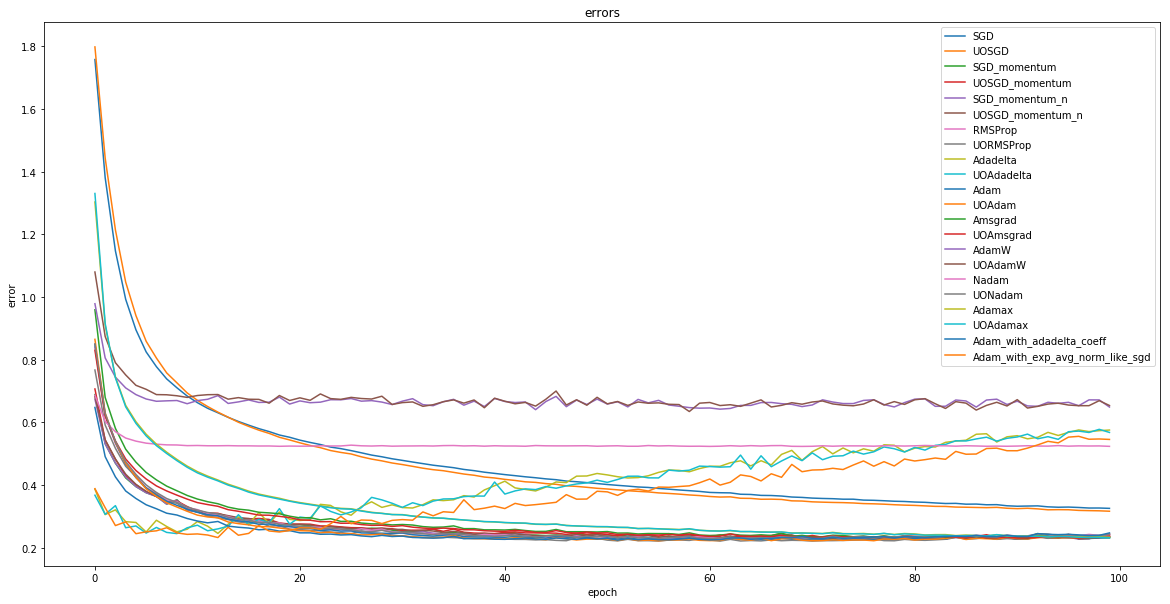

In [12]:
plot_graphs(test_log, 'loss', fs=(20, 10))

- Below we make a pairwise comparaison of standard algorithms and my implementation. Please note, that due to stochastic nature
of algorithms, the descent path could differ, but not too much. Exception for Nadam. For comparaison I use official implementation for Keras and it contains some hardcoded parameters that could not fit to any dataset. My implementation more classical and in case of this dataset looks better that Keras variant. 
- For better visualisation I excluded first 5 epochs, so below are the results from 6th epoch

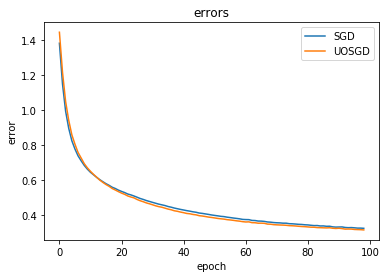

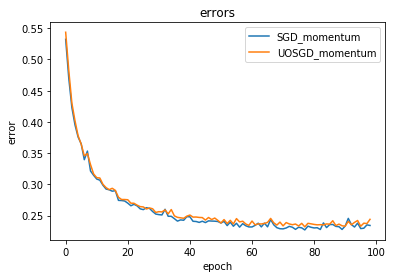

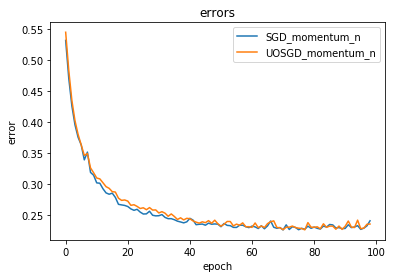

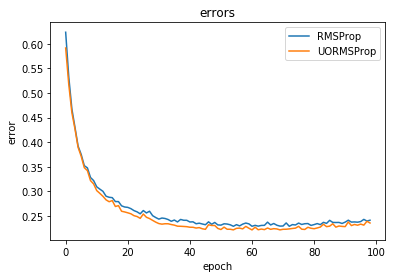

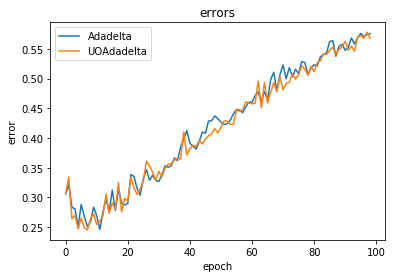

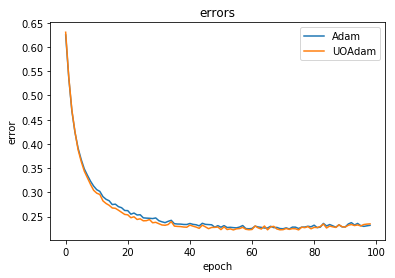

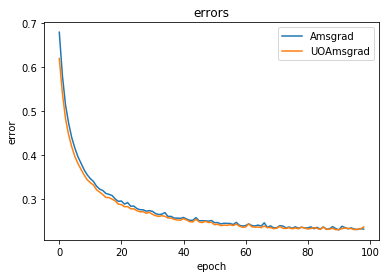

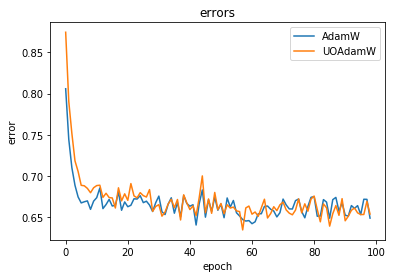

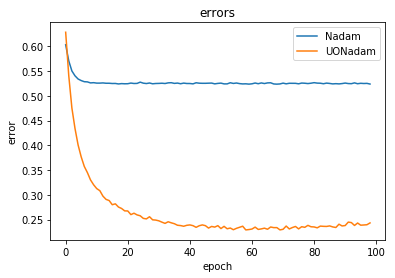

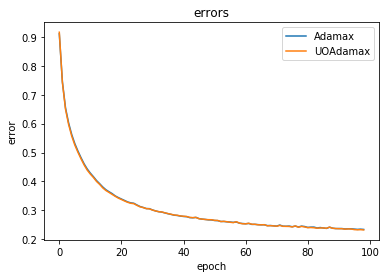

In [13]:
for i in ['SGD', 'SGD_momentum', 'SGD_momentum_n', 'RMSProp', 'Adadelta', 'Adam', 'Amsgrad', 'AdamW', 'Nadam', 'Adamax']:
    new_test_log = {}
    for k, v in test_log.items():
        if k == 'UO'+i or k==i:
            new_test_log[k] = v[1:]
    plot_graphs(new_test_log, 'loss')

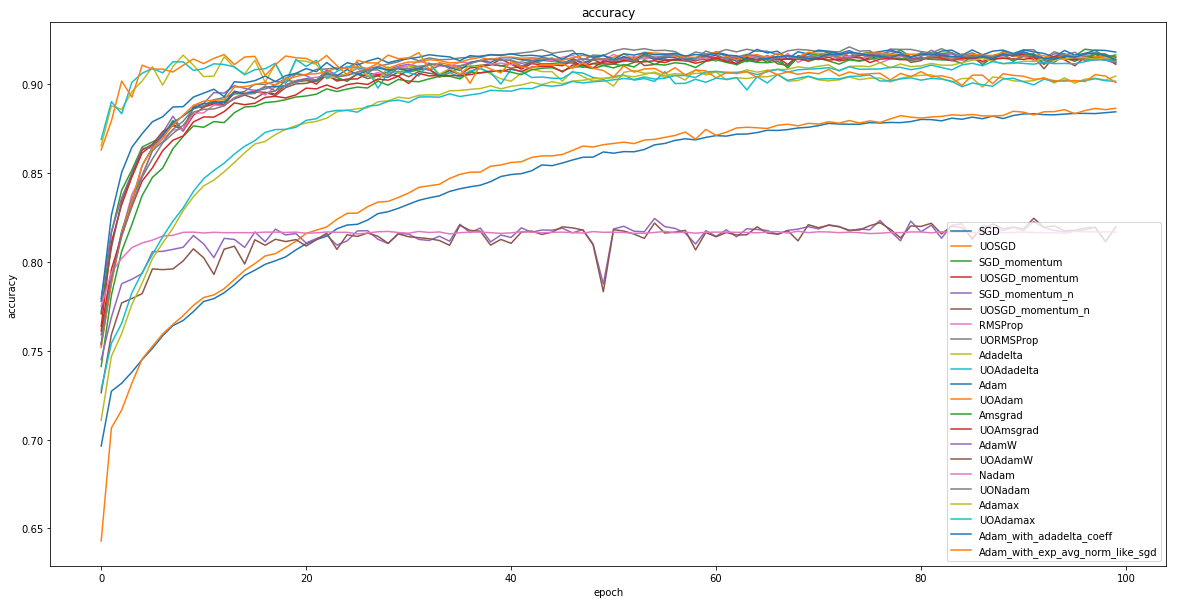

In [14]:
plot_graphs(test_log, 'accuracy', fs = (20, 10))

Now analyze dynamic of standard algorithms (we excluded the worst algos). It looks like three best algorithms (SGD with momentum, Amsgrad and Adam) demonstrate similar performance, though Adam is sligh better. 

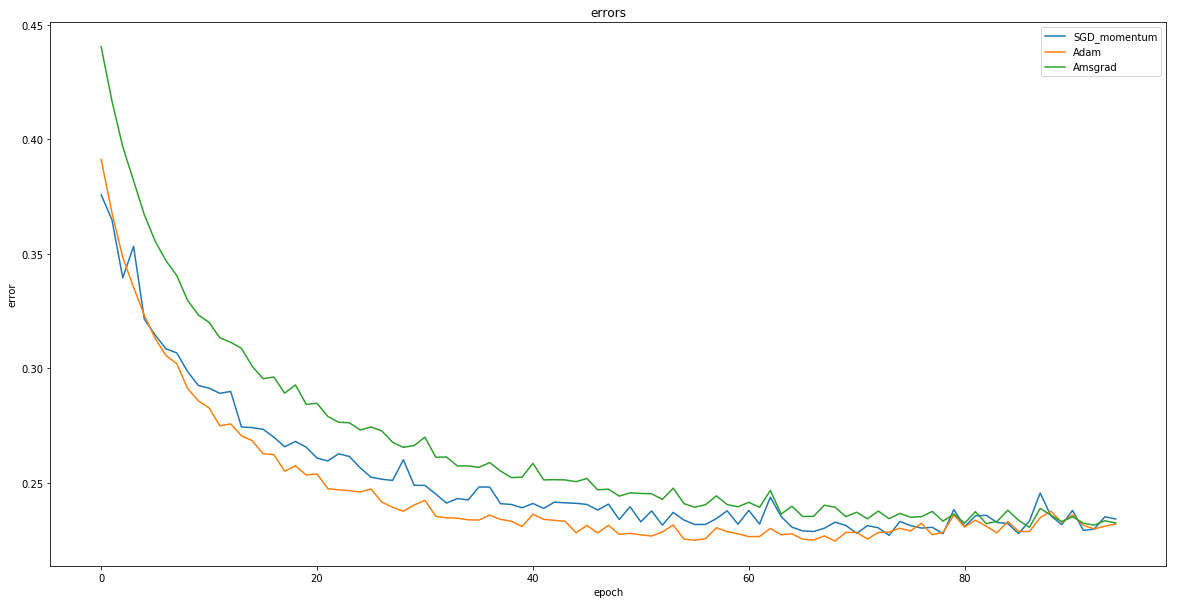

In [26]:
new_test_log = {}
for i in ['SGD_momentum', 'Adam', 'Amsgrad']:
    for k, v in test_log.items():
        if  k==i:
            new_test_log[k] = v[5:]
plot_graphs(new_test_log, 'loss', fs = (20, 10))

Lets compare best alogoritm with the exotic combinations of our algorithm. **It looks like our exotic combinations reach minimum faster than the best standard algoritms (12 epochs and 51 epochs). Then standard algoritms continue to decrease but after 100 epochs cannot beat the result of Adam_with_adadelta_coeff and just slightly better that Adam_with_exp_avg_norm_like_sgd after 12 epochs!**

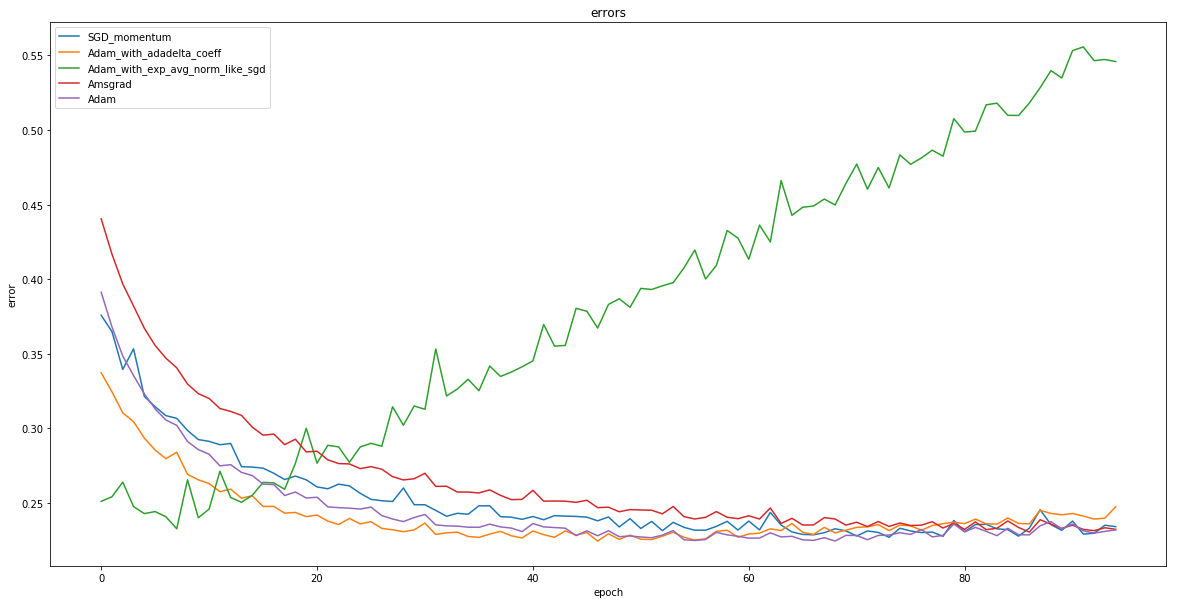

In [31]:
new_test_log = {}
for i in ['SGD_momentum','Adam_with_adadelta_coeff', 'Adam_with_exp_avg_norm_like_sgd', 'Amsgrad', 'Adam']:
    for k, v in test_log.items():
        if  k==i:
            new_test_log[k] = v[5:]
plot_graphs(new_test_log, 'loss', fs = (20, 10))

In [33]:
for i in ['SGD', 'SGD_momentum', 'SGD_momentum_n', 'RMSProp', 'Adadelta', 'Adam', 'Amsgrad', 'AdamW', 'Nadam', 'Adamax', 
         'Adam_with_adadelta_coeff', 'Adam_with_exp_avg_norm_like_sgd']:
    new_test_log = {}
    for k, v in test_log.items():
        if k==i:
            optim_loss = [x[0] for x in v]
        #     optim_accuracy =  [x[0] for x in v]
            print(f'for aloritm {k} the minimum loss is {np.min(optim_loss)} during epoch {np.argmin(optim_loss)}' )

for aloritm SGD the minimum loss is 0.32588093137741087 during epoch 99
for aloritm SGD_momentum the minimum loss is 0.227051331114769 during epoch 78
for aloritm SGD_momentum_n the minimum loss is 0.22669211783409118 during epoch 71
for aloritm RMSProp the minimum loss is 0.22881333799362183 during epoch 55
for aloritm Adadelta the minimum loss is 0.2459598069190979 during epoch 12
for aloritm Adam the minimum loss is 0.2245271186351776 during epoch 73
for aloritm Amsgrad the minimum loss is 0.23053675866127013 during epoch 91
for aloritm AdamW the minimum loss is 0.6406962793350219 during epoch 43
for aloritm Nadam the minimum loss is 0.5234764262199402 during epoch 69
for aloritm Adamax the minimum loss is 0.23411763830184937 during epoch 99
for aloritm Adam_with_adadelta_coeff the minimum loss is 0.22450541441440583 during epoch 51
for aloritm Adam_with_exp_avg_norm_like_sgd the minimum loss is 0.23276400697231292 during epoch 12
